**DATA** **PREPROCESSING**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/weatherAUS.csv')

Mounted at /content/drive


In [ ]:
df.shape

(145460, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [3]:
# create a table with data missing
missing_values=df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing ,
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %,data type
Date,0,0.000000,object
Location,0,0.000000,object
MinTemp,1485,1.020899,float64
MaxTemp,1261,0.866905,float64
Rainfall,3261,2.241853,float64
Evaporation,62790,43.166506,float64
Sunshine,69835,48.009762,float64
WindGustDir,10326,7.098859,object
WindGustSpeed,10263,7.055548,float64
WindDir9am,10566,7.263853,object


In [4]:
#remove rows with target variable null
df.dropna(subset=['RainTomorrow'], inplace=True)

<Axes: >

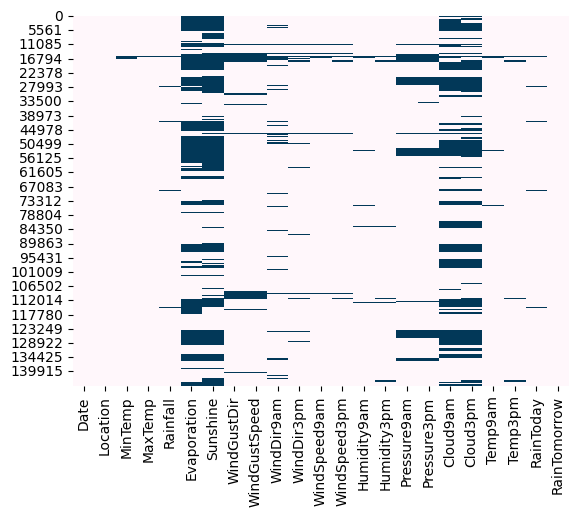

In [ ]:
# Missing Data Pattern in Training Data
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu')

In [ ]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,67816,0.476929
Evaporation,60843,0.427890
Cloud3pm,57094,0.401525
Cloud9am,53657,0.377353


In [5]:
df.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
       'RainToday', 'RainTomorrow'],
      dtype='object')

In [6]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

<ipython-input-6-09148030d9c7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
<ipython-input-6-09148030d9c7>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
<ipython-input-6-091

In [7]:
# Impute categorical var with Mode
df['Date'] = df['Date'].fillna(df['Date'].mode()[0])
df['Location'] = df['Location'].fillna(df['Location'].mode()[0])
df['WindGustDir'] = df['WindGustDir'].fillna(df['WindGustDir'].mode()[0])
df['WindDir9am'] = df['WindDir9am'].fillna(df['WindDir9am'].mode()[0])
df['WindDir3pm'] = df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0])

In [8]:
# Convert categorical features to continuous features with Label Encoding
lencoders = {}
for col in df.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    df[col] = lencoders[col].fit_transform(df[col])

In [9]:
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
MiceImputed = df.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(df)

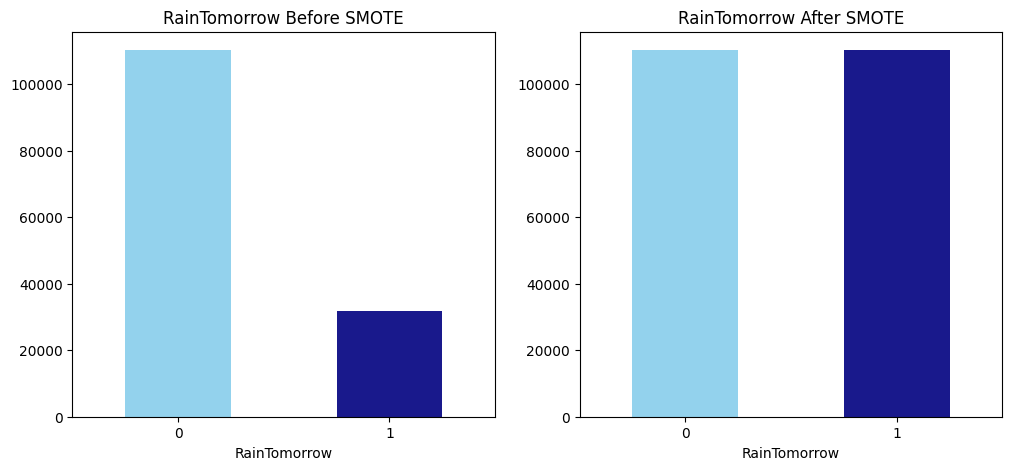

In [10]:
X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)

# Plot the class distribution before and after SMOTE
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
MiceImputed['RainTomorrow'].value_counts().plot(kind='bar', ax=ax[0], color=['skyblue', 'navy'], alpha=0.9, rot=0)
ax[0].set_title('RainTomorrow Before SMOTE')

# After SMOTE
resampled_df['RainTomorrow'].value_counts().plot(kind='bar', ax=ax[1], color=['skyblue', 'navy'], alpha=0.9, rot=0)
ax[1].set_title('RainTomorrow After SMOTE')

plt.show()

In [ ]:
resampled_df.shape

(220632, 23)

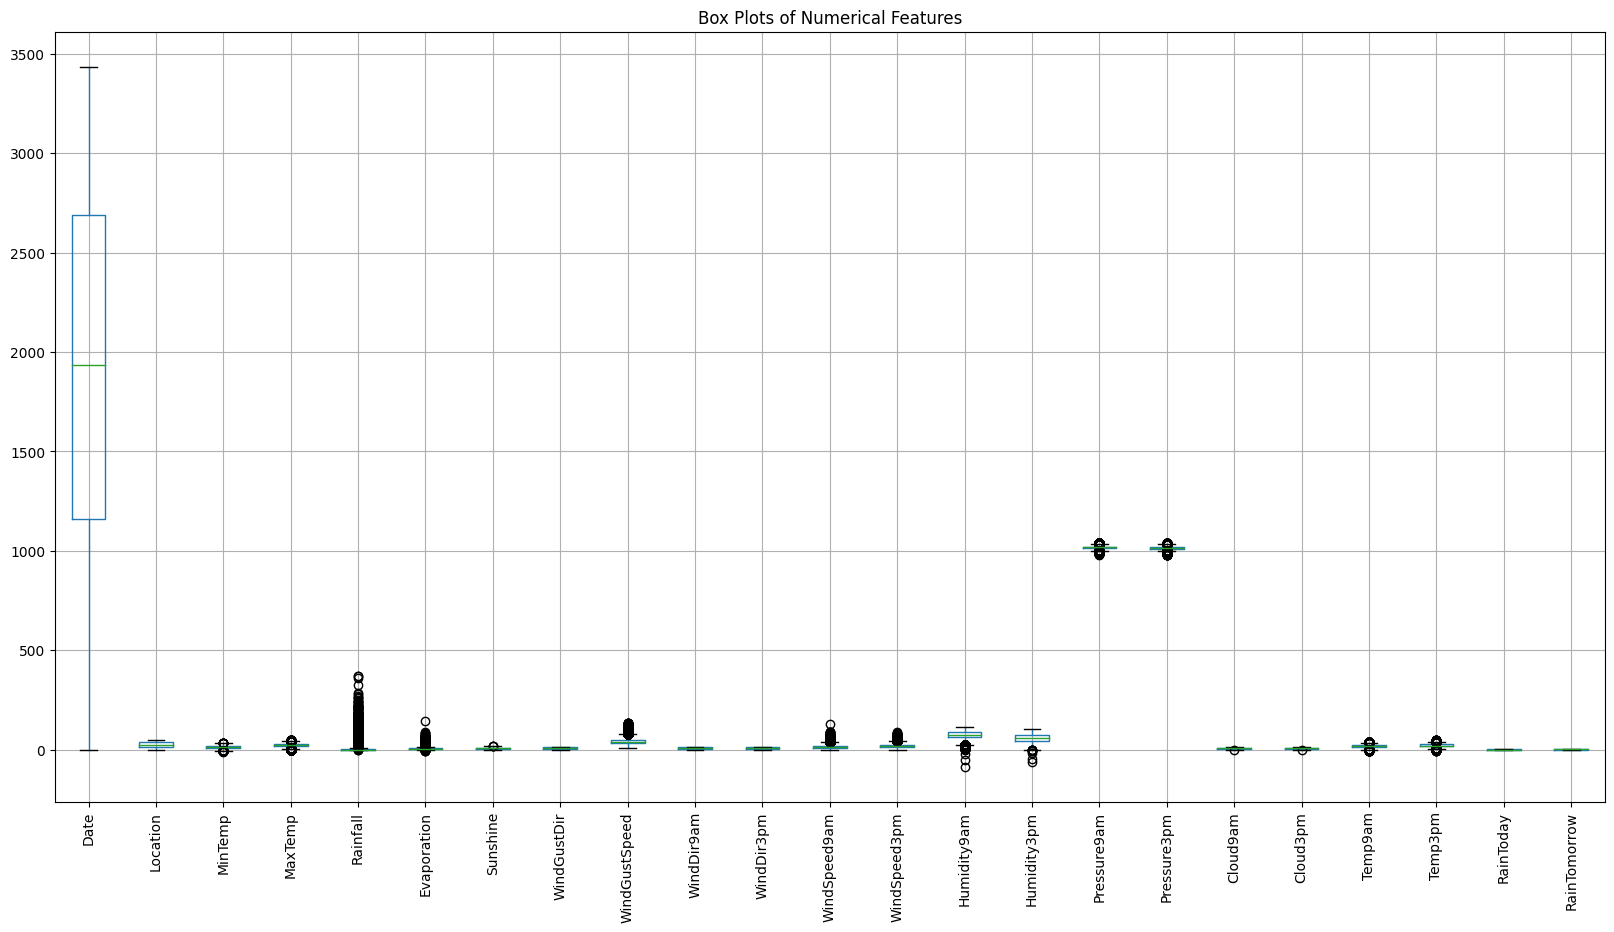

In [ ]:
plt.figure(figsize=(20, 10))
resampled_df.boxplot()
plt.xticks(rotation=90)
plt.title('Box Plots of Numerical Features')
plt.show()

<Axes: >

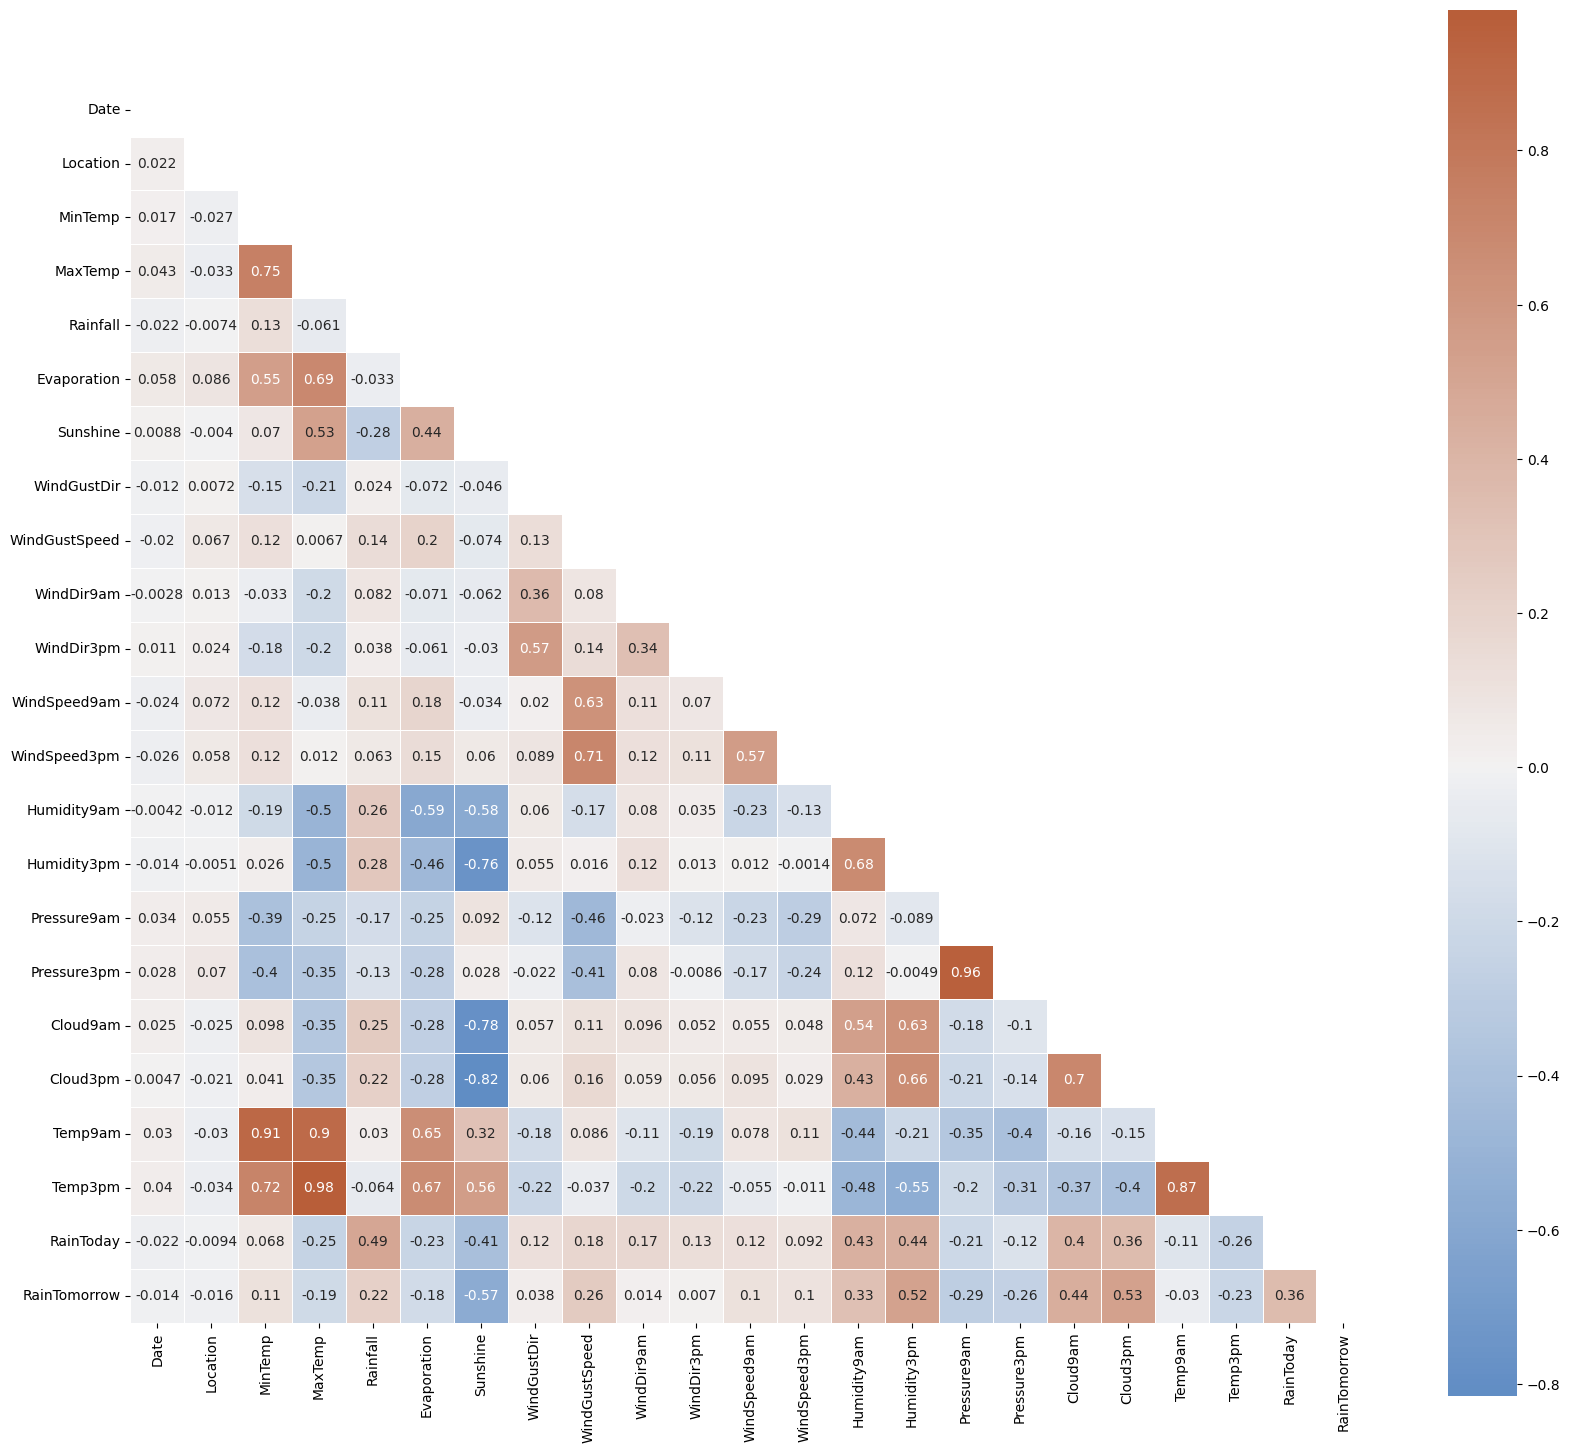

In [ ]:
# Correlation Heatmap
corr = resampled_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

The following feature pairs have a strong correlation with each other:
* MaxTemp and Temp3pm
* Pressure3pm and Pressure9am
* Temp9am and MinTemp
* Temp9am and MaxTemp
But in no case is the correlation value equal to a perfect “1”. We are therefore not removing any functionality


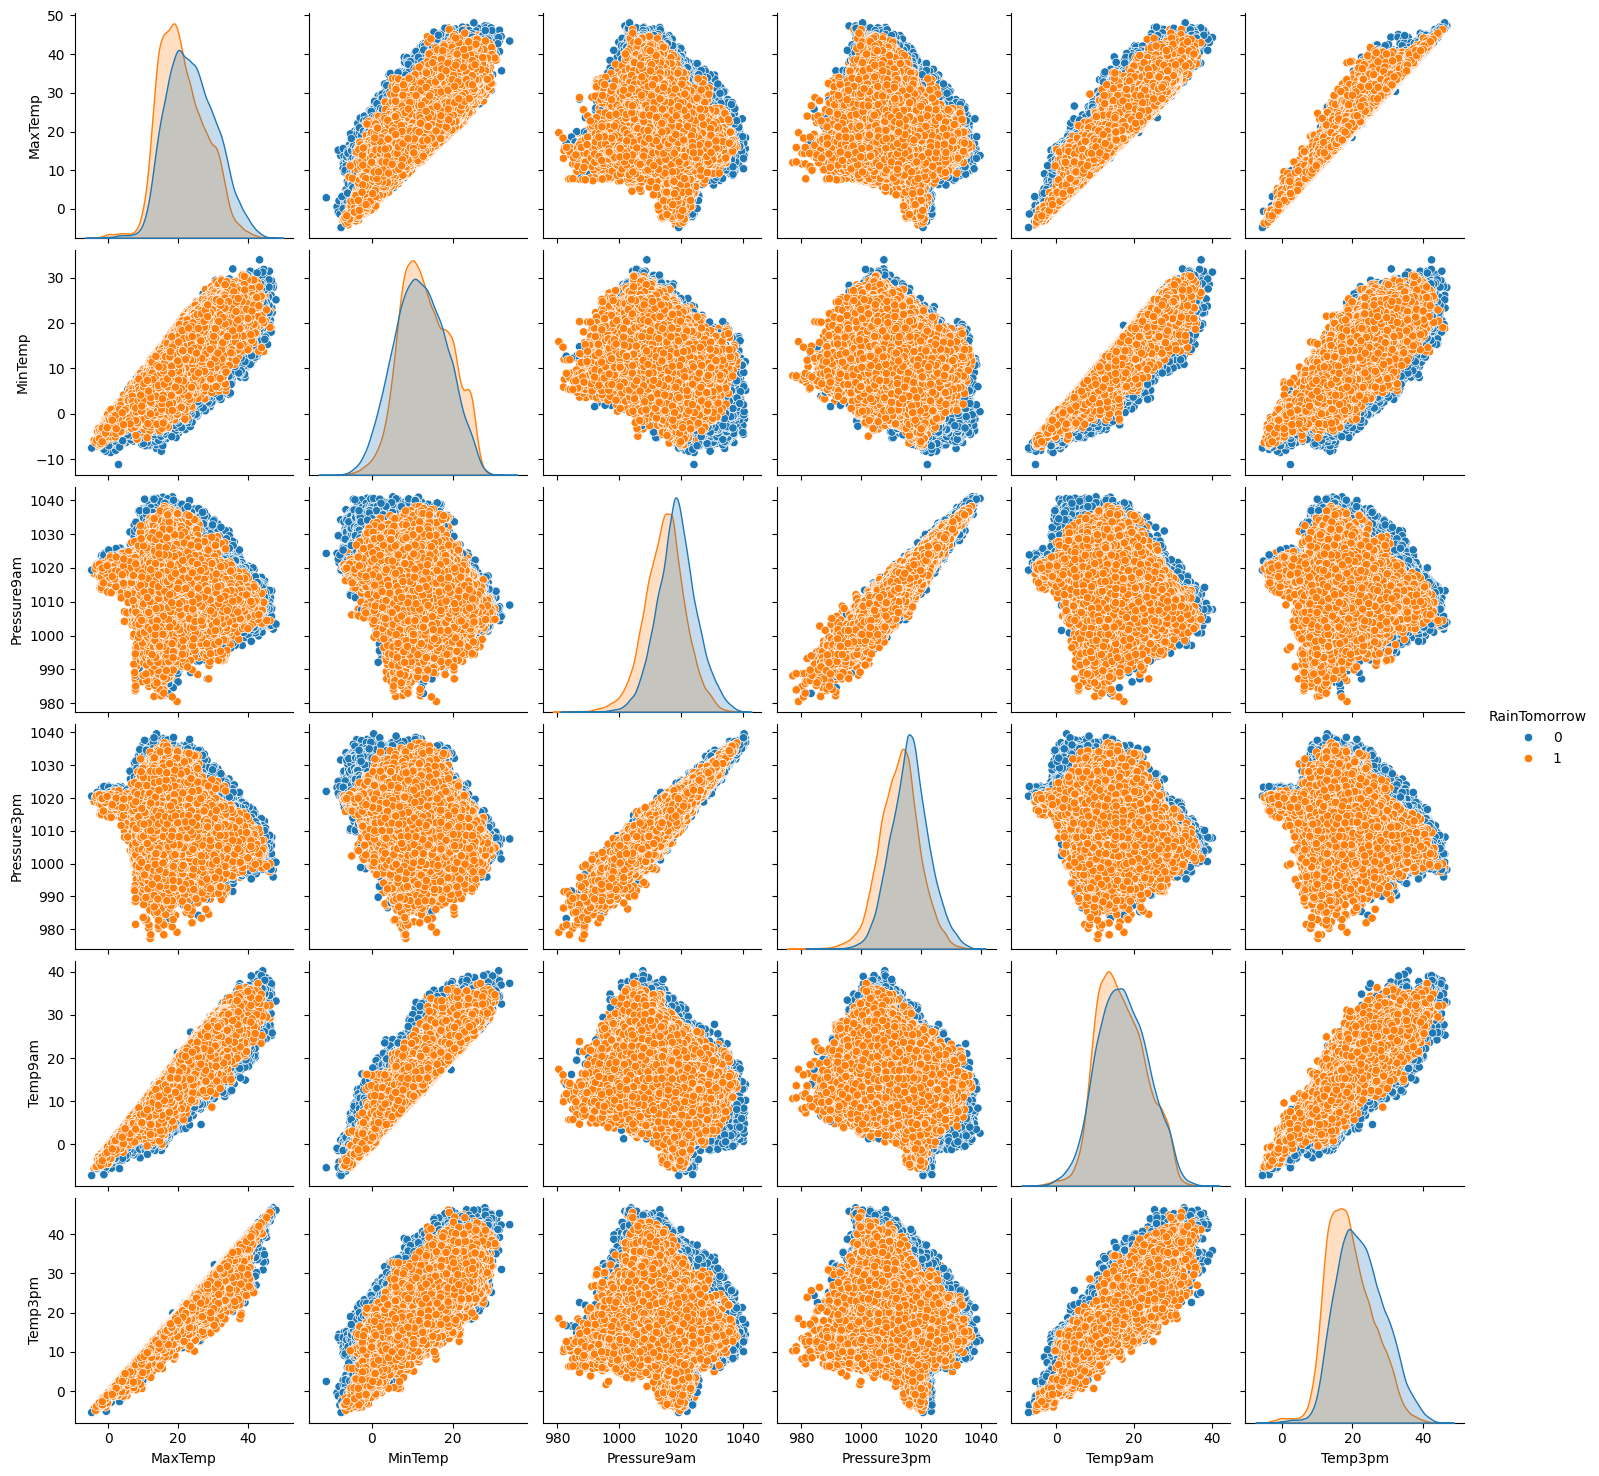

In [ ]:
sns.pairplot( data=resampled_df, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am','Temp3pm' ), hue='RainTomorrow' )

In [11]:
# Standardizing data
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(resampled_df)
modified_data = pd.DataFrame(r_scaler.transform(resampled_df), index=resampled_df.index,
                             columns=resampled_df.columns)
modified_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.115284,0.041667,0.544855,0.523629,0.013131,0.071880,0.444772,0.866667,0.292988,0.866667,...,0.781301,0.510689,0.449587,0.4800,0.823164,0.516418,0.508439,0.522073,0.218277,0.0
1,0.115575,0.041667,0.411641,0.565217,0.011532,0.071247,0.612625,0.933333,0.292988,0.400000,...,0.647020,0.528320,0.497521,0.4912,0.361180,0.346741,0.514768,0.570058,0.218277,0.0
2,0.115866,0.041667,0.533753,0.576560,0.011532,0.086712,0.649792,1.000000,0.308408,0.866667,...,0.617180,0.557704,0.447934,0.5056,0.368601,0.307121,0.594937,0.548944,0.218277,0.0
3,0.116157,0.041667,0.451605,0.620038,0.011532,0.074111,0.639943,0.266667,0.138784,0.600000,...,0.651993,0.475428,0.613223,0.5712,0.299536,0.295190,0.533755,0.612284,0.218277,0.0
4,0.116448,0.041667,0.635884,0.701323,0.014196,0.078423,0.387569,0.866667,0.269857,0.066667,...,0.836008,0.575334,0.500826,0.4624,0.748754,0.714717,0.527426,0.673704,0.218277,0.0


In [14]:
# Ensure 'RainTomorrow' is excluded from the feature selection process
# Separate features (X) and target variable (y)
X = modified_data.drop('RainTomorrow', axis=1)  # Ensure 'RainTomorrow' is excluded
y = modified_data['RainTomorrow']
# Select the 10 best features from the feature set (excluding 'RainTomorrow')
selector = SelectKBest(chi2, k=10)
X_selected = selector.fit_transform(X, y)

# Get the selected feature names (without the target variable)
selected_columns = X.columns[selector.get_support()]  # Use X.columns here
print("Selected columns:", selected_columns)

# Create a new dataframe with the selected features
modified_data_selected = pd.DataFrame(X_selected, columns=selected_columns)
modified_data_selected['RainTomorrow'] = y.values

# Proceed with balanced dataframe creation
balanced_df = (
    modified_data_selected.groupby('RainTomorrow')
    .apply(lambda x: x.sample(n=100, random_state=42))
    .reset_index(drop=True)
)

# Drop the selected datapoints from modified_data_selected
modified_data_remaining = pd.concat([modified_data_selected, balanced_df, balanced_df]).drop_duplicates(keep=False)

Selected columns: Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday'],
      dtype='object')


In [15]:
# Split the  data into train and test sets
X_new = modified_data_remaining.drop(columns=['RainTomorrow'])
y_remaining = modified_data_remaining['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X_new, y_remaining, test_size=0.2, random_state=42)

In [ ]:
# Define the parameter grid for ANN
param_grid_ann = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
}

# Create the GridSearchCV object for ANN
grid_search_ann = GridSearchCV(estimator=MLPClassifier(random_state=42), param_grid=param_grid_ann, cv=5)

# Fit the GridSearchCV object to the data
grid_search_ann.fit(X_train, y_train)

# Print the best parameters and best score for ANN
print("Best Parameters for ANN:", grid_search_ann.best_params_)
print("Best Score for ANN:", grid_search_ann.best_score_)

In [ ]:
# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}

# Create the GridSearchCV object for SVM
grid_search_svm = GridSearchCV(estimator=SVC(random_state=42), param_grid=param_grid_svm, cv=5)

# Fit the GridSearchCV object to the data
grid_search_svm.fit(X_train, y_train)

# Print the best parameters and best score for SVM
print("Best Parameters for SVM:", grid_search_svm.best_params_)
print("Best Score for SVM:", grid_search_svm.best_score_)

In [ ]:
# Define the parameter grid for RF
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}

# Create the GridSearchCV object for RF
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=5)

# Fit the GridSearchCV object to the data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and best score for RF
print("Best Parameters for RF:", grid_search_rf.best_params_)
print("Best Score for RF:", grid_search_rf.best_score_)

In [18]:
# 1. Artificial Neural Network (ANN)
ann_model = MLPClassifier(random_state=42, verbose=1, hidden_layer_sizes=(100, 50), activation='relu',
                          solver='adam')
ann_model.fit(X_train, y_train)
ann_predictions = ann_model.predict(X_test)
ann_accuracy = accuracy_score(y_test, ann_predictions)
print("ANN Accuracy:", ann_accuracy)

Iteration 1, loss = 0.43651487
Iteration 2, loss = 0.38840111
Iteration 3, loss = 0.37594243
Iteration 4, loss = 0.37129941
Iteration 5, loss = 0.36865637
Iteration 6, loss = 0.36661166
Iteration 7, loss = 0.36528423
Iteration 8, loss = 0.36389742
Iteration 9, loss = 0.36247856
Iteration 10, loss = 0.36196352
Iteration 11, loss = 0.35950131
Iteration 12, loss = 0.35766049
Iteration 13, loss = 0.35606379
Iteration 14, loss = 0.35334773
Iteration 15, loss = 0.35048335
Iteration 16, loss = 0.34736537
Iteration 17, loss = 0.34443511
Iteration 18, loss = 0.34145407
Iteration 19, loss = 0.33943339
Iteration 20, loss = 0.33580389
Iteration 21, loss = 0.33361981
Iteration 22, loss = 0.33063725
Iteration 23, loss = 0.32881506
Iteration 24, loss = 0.32499123
Iteration 25, loss = 0.32321478
Iteration 26, loss = 0.31933495
Iteration 27, loss = 0.31909035
Iteration 28, loss = 0.31709312
Iteration 29, loss = 0.31540374
Iteration 30, loss = 0.31448116
Iteration 31, loss = 0.31188375
Iteration 32, los

In [19]:
#ANN model training accuracy
ann_model.score(X_train,y_train)

0.8817148203805041